In [1]:

# leba3207
from unicodedata import category
from tqdm import tqdm
import heapq

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import RandomForestRegressor

import difflib
from functools import partial

Chargement des donnÃ©es des diffÃ©rents fichiers

In [2]:

data_folder = 'data/'

journal_file = 'api_journal11-13-17.csv'
price_file = 'api_price11-13-17.csv'
influence_file = 'estimated-article-influence-scores-2015.csv'

journal = pd.read_csv(data_folder + journal_file, sep=',', encoding='latin1')
price = pd.read_csv(data_folder + price_file, sep=',', index_col=0)
influence = pd.read_csv(data_folder + influence_file, sep=',', index_col=0)


In [3]:

def get_uniqueness_attributes(table):
    return table.nunique(axis=0)


def get_ratio_missing_values(table):
    return table.isnull().sum() * 100 / len(table)


def get_unique_values_of_attribute(table, header):
    return table[header].unique()


def lowercase_columns(table, headers):
    for header in headers:
        table[header] = table[header].str.lower()


# TODO: include headers specification
def get_df_duplicated_rows_dropped(table):
    return table.drop_duplicates()


def plot_categories_frequency(table, header):
    fig, ax = plt.subplots()
    table[header].value_counts()[0:5].plot(ax=ax, kind='bar')
    plt.title(f'FrÃ©quence d\'apparition des catÃ©gories de l\'attribut {header}')
    plt.show()


def get_mean_price_per_year():
    mean_price_per_year = {}
    for index, p in price.iterrows():
        year = p['date_stamp'].year
        if year in mean_price_per_year:
            mean_price_per_year[year] += p['price']
        else:
            mean_price_per_year[year] = p['price']

    for year, value in mean_price_per_year.items():
        mean_price_per_year[year] /= len(price[price['price'] != 0])
    return {k: v for k, v in sorted(mean_price_per_year.items(), key=lambda item: item[1], reverse=True)}


def rename_df_headers(table, dict_headers):
    return table.rename(columns=dict_headers)


def get_score_sequence_matching(s, c1, category):
    if s[c1] is np.nan:
        return 0
    return difflib.SequenceMatcher(None, s[c1], category).ratio()


def get_empty_attribute_to_remove(table):
    headers = []
    for header in table.columns:
        if table[header].isna().sum() * 100 / len(table) > 50:
            headers.append(header)
    return headers


# Question 1: Exploration-Description
## PrÃ©senter une description de chacun des attributs des 3 tables, avec des graphiques pour la visualisation des 
statistiques descriptives au besoin.

### Table journal

In [4]:
# TODO: visualisations
# frÃ©quence des valeurs

In [5]:

print(journal.head())

        issn                                       journal_name  \
0  0001-527X                           Acta Biochimica Polonica   
1  0002-0397                                    Africa Spectrum   
2  0003-0090  Bulletin of the American Museum of Natural His...   
3  0003-5521                                    L'anthropologie   
4  0004-1254  Arhiv Za Higijenu Rada I Toksikologiju-Archive...   

                      pub_name  is_hybrid                    category  url  
0     ACTA BIOCHIMICA POLONICA          0  MOLECULAR AND CELL BIOLOGY  NaN  
1                          NaN          0                         NaN  NaN  
2  AMER MUSEUM NATURAL HISTORY          0       ECOLOGY AND EVOLUTION  NaN  
3                     Elsevier          1                Anthropology  NaN  
4                          NaN          0                         NaN  NaN  


In [6]:

"""
issn: identifiant du journal
Les valeurs de cet attribut semblent suivre un format particulier tel que: 4 digits - 4 digits

journal_name: nom textuel du journal
Les valeurs sont textuelles, ne suivant pas de valeurs catÃ©gorielles particuliÃ¨re Ã  priori.

pub_name: nom de l'Ã©diteur du journal
Les valeurs sont textuelles, ne suivant pas de valeurs catÃ©gorielles particuliÃ¨re Ã  priori.

is_hybrid: indique si le journal est hybride, ce qui signifie que c'est une revue sur abonnement dont certains articles
sont en libre accÃ¨s, comme l'indique le site http://flourishoa.org/about.

category: renseigne sur la/les catÃ©gorie(s) des sujets abordÃ©s par le journal 
Les valeurs sont textuelles et sont catÃ©gorielles. Chaque objet peut possÃ©der des valeurs multiples pour cet attribut. La sÃ©paration entre les diffÃ©rentes valeurs semblent
Ãªtre inconsistante.

url: indique l'adresse url du site du journal


Les attributs journal_name, pub_name et category Ã©tant des donnÃ©es textuelles trÃ¨s inconsistantes, je dÃ©cide avant tout
traitement et Ã©tude supplÃ©mentaire de transformer les valeurs en minuscule pour limiter au maximum l'inconsistence.
"""

"\nissn: identifiant du journal\nLes valeurs de cet attribut semblent suivre un format particulier tel que: 4 digits - 4 digits\n\njournal_name: nom textuel du journal\nLes valeurs sont textuelles, ne suivant pas de valeurs catÃ©gorielles particuliÃ¨re Ã\xa0 priori.\n\npub_name: nom de l'Ã©diteur du journal\nLes valeurs sont textuelles, ne suivant pas de valeurs catÃ©gorielles particuliÃ¨re Ã\xa0 priori.\n\nis_hybrid: indique si le journal est hybride, ce qui signifie que c'est une revue sur abonnement dont certains articles\nsont en libre accÃ¨s, comme l'indique le site http://flourishoa.org/about.\n\ncategory: renseigne sur la/les catÃ©gorie(s) des sujets abordÃ©s par le journal \nLes valeurs sont textuelles et sont catÃ©gorielles. Chaque objet peut possÃ©der des valeurs multiples pour cet attribut. La sÃ©paration entre les diffÃ©rentes valeurs semblent\nÃªtre inconsistante.\n\nurl: indique l'adresse url du site du journal\n\n\nLes attributs journal_name, pub_name et category Ã©tant 

In [7]:

lowercase_columns(journal, ['journal_name', 'pub_name', 'category'])

In [8]:

print(f"Valeurs uniques des attributs de journal:\n"
      f"{get_uniqueness_attributes(journal)}")
print(f"Ratio de valeurs vides pour les attributs de journal:\n"
      f"{get_ratio_missing_values(journal)}")

print(f"Valeurs possibles pour l'attribut is_hybrid de journal:\n"
      f"{get_unique_values_of_attribute(journal, 'is_hybrid')}")
print(f"Valeurs possibles pour l'attribut category de journal:\n"
      f"{get_unique_values_of_attribute(journal, 'category')}")

Valeurs uniques des attributs de journal:
issn            13149
journal_name    11572
pub_name         3490
is_hybrid           2
category          112
url              6327
dtype: int64
Ratio de valeurs vides pour les attributs de journal:
issn             0.000000
journal_name     0.000000
pub_name        11.179557
is_hybrid        0.000000
category        48.148148
url             51.623698
dtype: float64
Valeurs possibles pour l'attribut is_hybrid de journal:
[0 1]
Valeurs possibles pour l'attribut category de journal:
['molecular and cell biology' nan 'ecology and evolution' 'anthropology'
 'robotics' 'physics and chemistry' 'psychology' 'medicine' 'neuroscience'
 'veterinary' 'economics' 'law' 'gastroenterology' 'plant biology'
 'orthopedics' 'agriculture' 'linguistics'
 'history and philosophy of science' 'mathematics' 'oncology'
 'sports medicine' 'food science' 'psychiatry' 'science' 'radiology'
 'urology' 'environmental health' 'social sciences' 'ophthalmology'
 'marketing' '

Les attributs category et url prÃ©sentent un nombre consÃ©quent de valeurs manquantes.
L'attribut issn prÃ©sente des valeurs uniques pour chacun de ses objets.

On remarque qu'il existe uniquement deux valeurs pour l'attribut is_hybrid (soit 1 soit 0). 

In [9]:

print(f"Valeurs possibles de pub_name quand is_hybrid vaut 1:\n"
      f"{journal[journal['is_hybrid'] == 1]['pub_name'].unique()}")

Valeurs possibles de pub_name quand is_hybrid vaut 1:
['elsevier' 'springer' 'sage publishing' 'wolters kluwer health']


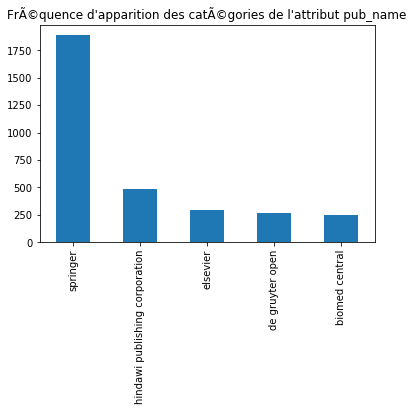

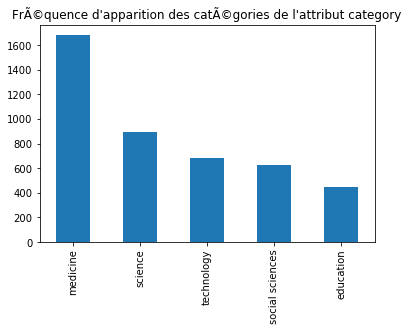

In [10]:

plot_categories_frequency(journal, 'pub_name')
plot_categories_frequency(journal, 'category')

### Table price

In [11]:

print(price.head())

       price  date_stamp journal_id  influence_id  url  license
id                                                             
8691  1400.0  2016-08-11  2051-5960           NaN  NaN      NaN
8692  2175.0  2016-08-11  1758-9193           NaN  NaN      NaN
8693  2145.0  2016-08-11  1476-0711           NaN  NaN      NaN
8694  2145.0  2016-08-11  2047-2994           NaN  NaN      NaN
8695  2145.0  2016-08-11  1744-9081           NaN  NaN      NaN


price: information du prix d'une publication pour le journal associÃ© Ã  une date prÃ©cise, en dollar US
Si celui-ci est Ã  0, on peut coompendre que celui-ci est gratuit

date_stamp: horodatage de l'information de prix d'une publication, en format annÃ©es-mois-jour

journal_id: identifiant du journal
Les valeurs semblent suivre consistantement un format du type: 4 digits - 4 digits

influence_id: identifiant de l'influence
Les valeurs suivent un format 4 digits.

url: indique l'adresse url du site de l'auteur

license: indique le type de license utilisÃ© par le journal pour les diffÃ©rents articles utilisÃ©s.


On convertit l'attribut date_stamp en type date.

In [12]:

price['date_stamp'] = pd.to_datetime(price['date_stamp'], errors='coerce', format='%Y-%m-%d')

In [13]:

print(f"Valeurs uniques des attributs de price:\n"
      f"{get_uniqueness_attributes(price)}")
print(f"Ratio de valeurs vides pour les attributs de price:\n"
      f"{get_ratio_missing_values(price)}")

print(f"Exemples de valeurs possibles pour l'attribut influence_id de price:\n"
      f"{get_unique_values_of_attribute(price, 'influence_id')[1:8]}")
print(f"Valeurs possibles pour l'attribut license de price:\n"
      f"{get_unique_values_of_attribute(price, 'license')}")

Valeurs uniques des attributs de price:
price            527
date_stamp      1472
journal_id      5720
influence_id     759
url              302
license            8
dtype: int64
Ratio de valeurs vides pour les attributs de price:
price            0.000000
date_stamp       0.000000
journal_id       0.000000
influence_id    90.262989
url             95.330340
license         95.150738
dtype: float64
Exemples de valeurs possibles pour l'attribut influence_id de price:
[4519. 4517. 4516. 4515. 4514. 4513. 4512.]
Valeurs possibles pour l'attribut license de price:
[nan  1. 10.  4.  5.  6.  2.  3.  9.]


Les attributs influence_id, url et license prÃ©sentent une majoritÃ© de valeurs manquantes.

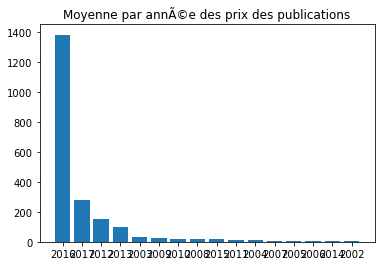

In [14]:

mean_price_per_year = get_mean_price_per_year()

plt.bar(range(len(mean_price_per_year)), mean_price_per_year.values())
plt.xticks(range(len(mean_price_per_year)), mean_price_per_year.keys())
plt.title("Moyenne par annÃ©e des prix des publications")
plt.show()

### Table influence

In [15]:

print(influence.head())

# TODO: proj_ai moyenne

                    journal_name       issn  citation_count_sum  \
0                    3d research  2092-6731               151.0   
1              aaps pharmscitech  1530-9932              2208.0   
2  abstract and applied analysis  1687-0409              3005.0   
3            academic psychiatry  1545-7230               537.0   
4             academic questions  1936-4709                40.0   

   paper_count_sum  avg_cites_per_paper  proj_ai  proj_ai_year  
0            106.0             1.424528    0.290          2015  
1            801.0             2.756554    0.665          2015  
2           2923.0             1.028053    0.192          2015  
3            490.0             1.095918    0.208          2015  
4             67.0             0.597015    0.097          2015  


journal_name: nom textuel du journal
Les valeurs sont textuelles, ne suivant pas de valeurs catÃ©gorielles particuliÃ¨re Ã  priori.

issn: identifiant du journal
Les valeurs de cet attribut semblent suivre un format particulier tel que: 4 digits - 4 digits

citation_count_sum: indique le nombre de citations du jounal

paper_count_sum: indique le nombre de citations des articles du jounal

avg_cites_per_paper: indique la moyenne des citations par papier qui sont contenus du journal

proj_ai: information sur le score d'influence des articles du journal

proj_ai_year: spÃ©cification de l'annÃ©e oÃ¹ l'information sur le score d'influence des articles du journal a Ã©tÃ© Ã©tablie

In [16]:

print(f"Valeurs uniques des attributs de influence:\n"
      f"{get_uniqueness_attributes(influence)}")
print(f"Ratio de valeurs vides pour les attributs de influence:\n"
      f"{get_ratio_missing_values(influence)}")

print(f"Valeurs possibles pour l'attribut proj_ai_year de influence:\n"
      f"{get_unique_values_of_attribute(influence, 'proj_ai_year')}")

Valeurs uniques des attributs de influence:
journal_name           3169
issn                   3615
citation_count_sum     1542
paper_count_sum        1099
avg_cites_per_paper    2932
proj_ai                1151
proj_ai_year              1
dtype: int64
Ratio de valeurs vides pour les attributs de influence:
journal_name           0.00000
issn                   0.00000
citation_count_sum     0.33195
paper_count_sum        0.33195
avg_cites_per_paper    0.33195
proj_ai                0.33195
proj_ai_year           0.00000
dtype: float64
Valeurs possibles pour l'attribut proj_ai_year de influence:
[2015]


L'attribut proj_ai_year ne prÃ©sentant qu'une seule valeur nous indique que les valeurs de l'attribut proj_ai ont toutes
Ã©tÃ© Ã©tablies Ã  la mÃªme pÃ©riode. 
"""

# TODO: proj_ai sum in function of journal

# Question 2: PrÃ©traitement-ReprÃ©sentation
## A. Effectuer un prÃ©traitement des donnÃ©es pour supprimer les duplications et corriger les incohÃ©rences sâ€™il y en a.

### Table journal
Dans un premier temps, on Ã©limine les objets prÃ©sentant des objets dupliquÃ©s sur tous les attributs.
On se base sur l'attribut issn qui devrait Ãªtre unique pour chaque objet de la table, on vÃ©rifie son unicitÃ©.

In [17]:

nb = len(journal)
journal = get_df_duplicated_rows_dropped(journal)
print(f"Nombre d'objets dupliquÃ©s Ã©liminÃ©s dans journal: {nb - len(journal)}")

check = np.logical_not(journal['issn'].duplicated().any())
print(f"UnicitÃ© de l'attribut issn dans la table journal: {check}")

Nombre d'objets dupliquÃ©s Ã©liminÃ©s dans journal: 0
UnicitÃ© de l'attribut issn dans la table journal: True


### Table price
Etant donnÃ© que les index Ã©taient fournis dans le fichier original et qu'on les utilise afin d'indexer nos objets, 
on vÃ©rifie qu'il n'existe pas de duplicata.

Ensuite, on Ã©limine les objets prÃ©sentant des objets dupliquÃ©s sur tous les attributs.
Dans un second temps, dans la table price, les objets se doivent d'Ãªtre uniques selon deux attributs, date_stamp et
journal_id. S'ils ne le sont pas, alors ceux sont des objets dupliquÃ©s.

In [18]:

check = np.logical_not(price.index.duplicated().any())
print(f"UnicitÃ© des indexes de la table price: {check}")

nb = len(price)
price = get_df_duplicated_rows_dropped(price)
print(f"Nombre d'objets dupliquÃ©s Ã©liminÃ©s dans price: {nb - len(price)}")

duplicated_rows = price[price[['date_stamp', 'journal_id']].duplicated(keep=False)]

UnicitÃ© des indexes de la table price: True
Nombre d'objets dupliquÃ©s Ã©liminÃ©s dans price: 3


Il existe des duplicata ambigus que l'on dÃ©cide de traiter un Ã  un.

Premier cas: un des objets prÃ©sente un prix nul, on dÃ©cide de choisir de l'Ã©liminer au profit de l'autre.

In [19]:

print(duplicated_rows.iloc[0].fillna(0) == duplicated_rows.iloc[1].fillna(0))
price = price.drop(duplicated_rows.index.values[0])

price           False
date_stamp       True
journal_id       True
influence_id     True
url              True
license          True
dtype: bool


DeuxiÃ¨me cas: leur valeur du prix est diffÃ©rente d'un lÃ©ger Ã©cart, on dÃ©cide de garder la deuxiÃ¨me de maniÃ¨re
arbitraire

In [20]:

print(duplicated_rows.iloc[40].fillna(0) == duplicated_rows.iloc[41].fillna(0))
price = price.drop(duplicated_rows.index.values[40])

price           False
date_stamp       True
journal_id       True
influence_id     True
url              True
license          True
dtype: bool


TroisiÃ¨me cas: seule la valeur de license est diffÃ©rente, on dÃ©cide de garder la premiÃ¨re de maniÃ¨re arbitraire.

In [21]:

for i in range(3, 39, 2):
    price = price.drop(duplicated_rows.index.values[i])

### Table influence
Etant donnÃ© que les index Ã©taient fournis dans le fichier original et qu'on les utilise afin d'indexer nos objets, 
on vÃ©rifie qu'il n'existe pas de duplicata.

On se base sur l'attribut issn qui devrait Ãªtre unique pour chaque objet de la table, on vÃ©rifie son unicitÃ©.

In [22]:

nb = len(influence)
influence = get_df_duplicated_rows_dropped(influence)
print(f"Nombre d'objets dupliquÃ©s Ã©liminÃ©s dans influence: {nb - len(influence)}")

check = np.logical_not(influence['issn'].duplicated().any())
print(f"UnicitÃ© de l'attribut issn dans la table influence: {check}")

Nombre d'objets dupliquÃ©s Ã©liminÃ©s dans influence: 0
UnicitÃ© de l'attribut issn dans la table influence: True


## Merge
Afin de simplifier les opÃ©rations, on gÃ©nÃ¨re une seule table reprenant les informations des trois tables.
On vÃ©rifie d'abord si les identifiants communs aux diffÃ©rentes tables sont prÃ©sentes dans les tables Ã  merger.
En premier, on vÃ©rifie si les valeurs de l'attribut issn de influence sont existantes dans l'attribut du mÃªme nom 
dans journal.
De mÃªme, on vÃ©rifie les valeurs de l'attribut journal_id de price sont existantes dans l'attribut issn dans journal. 

In [23]:

check = influence['issn'].isin(journal['issn']).any()
print(f"Pas de valeur d'issn manquante dans journal par rapport Ã  influence : {check}")

check = price['journal_id'].isin(journal['issn']).any()
print(f"Pas de valeur d'issn manquante dans journal par rapport Ã  price : {check}")

Pas de valeur d'issn manquante dans journal par rapport Ã  influence : True
Pas de valeur d'issn manquante dans journal par rapport Ã  price : True


On applique maintenant le merge des trois tables en deux Ã©tapes. D'abord, on merge influence dans journal, puis price
est ensuite mergÃ© dans le rÃ©sultat du premier merge.

In [24]:

price = rename_df_headers(price, {"journal_id": "issn", "url": "url_autor"})
journal = rename_df_headers(journal, {"url": "url_journal"})

temp = pd.merge(journal, influence, on='issn', how='outer')
check = len(temp[temp['journal_name_x'] != temp['journal_name_y']])
print(f"Nombre d'aberrances entre les valeurs journal_name des tables journal et influence: {check}")
temp = temp.drop(columns=['journal_name_y'])
temp = rename_df_headers(temp, {"journal_name_x": "journal_name"})

print(f"Valeurs uniques des attributs de temp:\n"
      f"{get_uniqueness_attributes(temp)}")

data = pd.merge(temp, price, on=['issn'], how='outer')
data = get_df_duplicated_rows_dropped(data)

print(f"Valeurs uniques des attributs de data:\n"
      f"{get_uniqueness_attributes(data)}")
print(f"Ratio de valeurs vides pour les attributs de data:\n"
      f"{get_ratio_missing_values(data)}")

Nombre d'aberrances entre les valeurs journal_name des tables journal et influence: 9534
Valeurs uniques des attributs de temp:
issn                   13149
journal_name           11572
pub_name                3490
is_hybrid                  2
category                 112
url_journal             6327
citation_count_sum      1542
paper_count_sum         1099
avg_cites_per_paper     2932
proj_ai                 1151
proj_ai_year               1
dtype: int64
Valeurs uniques des attributs de data:
issn                   13149
journal_name           11572
pub_name                3490
is_hybrid                  2
category                 112
url_journal             6327
citation_count_sum      1542
paper_count_sum         1099
avg_cites_per_paper     2932
proj_ai                 1151
proj_ai_year               1
price                    527
date_stamp              1472
influence_id             759
url_autor                302
license                    8
dtype: int64
Ratio de valeurs vides p

On s'assure bien que les valeurs de l'attribut issn de la nouvelle date (data) sont uniques.

## B. Y-a-t-il une corrÃ©lation entre les catÃ©gories de journaux (attribut category) et les coÃ»ts de publication 
(attribut price)? Justifier la rÃ©ponse.

Afin de dÃ©terminer s'il existe une corrÃ©lation entre les catÃ©gories et l'attribut prix, on s'intÃ©resse Ã  chaque 
catÃ©gorie une Ã  une. 
Etant donnÃ© que chaque objet peut avoir plusieurs valeurs de catÃ©gories, on dÃ©cide de sÃ©parer les catÃ©gories selon les 
diffÃ©rents sÃ©parateurs observÃ©s (|, and, .). On les convertit ensuite en one hot.
On calcule ensuite la corrÃ©lation catÃ©gorie par catÃ©gorie avec l'attribut prix. Pour cela, on ne considÃ¨re que les 
objets prÃ©sentant la catÃ©gorie testÃ©e et les valeurs de prix associÃ©es.

In [25]:

cat_labelled_data = data[data['category'].notna()]
cat_data_to_predict = data[data['category'].isna()]

In [26]:

cat_labelled_data['category'] = cat_labelled_data['category'].str.replace(r'[\.\|&] | [\.\|&] | and ', '.', regex=True)
category_dummies = cat_labelled_data['category'].str.get_dummies(sep='.')
category_dummies_prefix = category_dummies.add_prefix('category_')
print(f'Nombre de catÃ©gories aprÃ¨s sÃ©paration: {category_dummies.shape[1]}')
# %%

cat_labelled_data = pd.concat([cat_labelled_data, category_dummies_prefix], axis=1) \
    # .drop(columns=['category'])

C:\Users\Agath\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Nombre de catÃ©gories aprÃ¨s sÃ©paration: 88


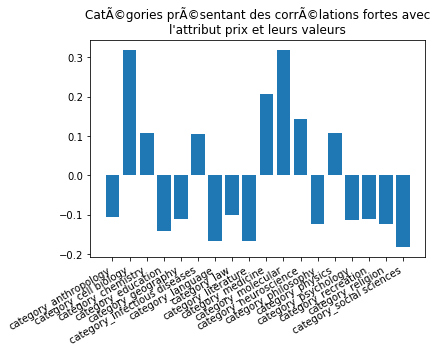

In [27]:

categories_correlation = {}

for header in category_dummies_prefix.columns:
    corr = cat_labelled_data[header].corr(cat_labelled_data['price'])
    if abs(corr) > 0.1:
        categories_correlation[header] = corr

fig, ax = plt.subplots()
plt.bar(categories_correlation.keys(), categories_correlation.values())
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.title(f'CatÃ©gories prÃ©sentant des corrÃ©lations fortes avec\nl\'attribut prix et leurs valeurs')
plt.show()

On remarque que certaines catÃ©gories prÃ©sentent effectement une lÃ©gÃ¨re corrÃ©lation avec l'attribut prix.
(Les catÃ©gories prÃ©sentant une corrÃ©lation infÃ©rieures Ã  0.1 ne sont pas incluses dans le graphe)
Les catÃ©gories prÃ©sentant la plus forte corrÃ©lation sont 'cell biology' et 'molecular'.
Cependant, cette corrÃ©lation remarquÃ©e est trÃ¨s faible et peut Ãªtre nÃ©gligeable.

## C. Construire un modÃ¨le pour prÃ©dire les valeurs de catÃ©gorie de journaux manquantes de la faÃ§on la plus prÃ©cise
possible (cela inclut la sÃ©lection dâ€™attributs informatifs, le choix et le paramÃ©trage dâ€™un modÃ¨le de classification,
le calcul du score du modÃ¨le, lâ€™application du modÃ¨le pour prÃ©dire les catÃ©gories manquantes). Justifier les choix
effectuÃ©s.
TODO: remove attributes price and citations from 2.C and ajust justification
Dans le but de prÃ©dire les catÃ©gories de journaux, on doit s'intÃ©resser Ã  plusieurs attributs qui pourraient nous
aider. Le nom du journal pourrait inclure certains mots-clÃ©s qui pourraient s'apparenter aux catÃ©gories du journal.
Le nom de l'Ã©diteur pourrait Ã©galement apporter de l'information sur les catÃ©gories.
Etant donnÃ© qu'on a pu trouver certaines corrÃ©lations entre l'attribut prix et les catÃ©gories, on prend Ã©galement en
compte ce paramÃ¨tre.
Les informations de citation du journal pourraient Ã©galement se rÃ©vÃ©ler porteuses d'informations, ainsi que l'influence
des articles.

In [28]:

cat_labelled_data = cat_labelled_data[cat_labelled_data['price'].notna()]
headers = ['citation_count_sum', 'paper_count_sum', 'avg_cites_per_paper', 'proj_ai', 'price']
cat_labelled_data = cat_labelled_data.dropna(axis=0, subset=headers)

In [29]:

for header in tqdm(category_dummies.columns):
    cat_labelled_data['jn_' + header] = cat_labelled_data.apply(partial(get_score_sequence_matching, c1='journal_name',
                                                                category=header), axis=1)
    cat_labelled_data['pn_' + header] = cat_labelled_data.apply(partial(get_score_sequence_matching, c1='pub_name',
                                                                category=header), axis=1)

100%|██████████████████████████████████████████████████████████████████████████████████| 88/88 [01:25<00:00,  1.04it/s]


In [30]:

cat_labelled_data = cat_labelled_data.drop(columns=['category'])
print(f'size cat_labelled_data before splitting: {cat_labelled_data.shape[0]}')

size cat_labelled_data before splitting: 2140


In [31]:

jn_sm_headers = cat_labelled_data.filter(like='jn_').columns.to_list()
pn_sm_headers = cat_labelled_data.filter(like='pn_').columns.to_list()
# TODO: add date_stamp to attributes_of_interest
attributes_of_interest = ['citation_count_sum', 'paper_count_sum', 'avg_cites_per_paper', 'proj_ai', 'price',
                          # 'date_stamp',
                          ]
attributes_of_interest.extend(jn_sm_headers)
attributes_of_interest.extend(pn_sm_headers)

### Entrainement
On applique des modÃ¨les de classification ayant la capacitÃ© de pouvoir prÃ©duire des labels multiples.
Pour cela, on utilise la mÃ©thode MultiOutputClassifier de sklearn afin qui consiste Ã  adapter un classificateur par
cible.
A partir de lÃ , on a pu essayer plusieurs types de classification, les deux meilleurs se sont rÃ©vÃ©lÃ©s Ãªtre les random
forest et les K plus proches voisins.

Le code suivant sert Ã  faire une recherche d'hyperparamÃ¨tres (succinte) sur un classification random forest.
Pour le confort du temps de compilation, je n'ai pas intÃ©grÃ© au rendu le classification K plus proche voisin, cependant
le rÃ©sultat du meilleur modÃ¨le trouvÃ© est dÃ©crit ci-dessous.

In [32]:

clfs = {'RandomForestClassifier': RandomForestClassifier()}

best_model = {'name': '', 'score': 0, 'model': None}
for name, clf in clfs.items():
    # for i in range(15, 17): # TODO
    for i in range(13, 14):
        X_train, X_test, y_train, y_test = train_test_split(cat_labelled_data[attributes_of_interest],
                                                            cat_labelled_data[category_dummies_prefix.columns],
                                                            test_size=0.33, random_state=42)
        X_train = X_train[attributes_of_interest]
        X_test = X_test[attributes_of_interest]
        y_train = y_train.to_numpy()

        clf.set_params(max_depth=i)

        print(f'ModÃ¨le {name} {i}')
        print('-- Entrainement')
        classifier = MultiOutputClassifier(clf, n_jobs=-1)
        classifier.fit(X_train, y_train)
        train_score = classifier.score(X_train, y_train)
        print(f'Score d\'entraÃ®nement: {train_score}')

        print('-- Test')
        test_predictions = classifier.predict(X_test)
        test_score = classifier.score(X_test, y_test)
        print(f'Score de test: {test_score}')

        if test_score > best_model.get('score'):
            best_model['name'], best_model['score'], best_model['model'] = name + ' ' + str(i), test_score, classifier

print(f"Le modÃ¨le prÃ©sentant le meilleur score est {best_model.get('name')} avec {best_model.get('score')}")

ModÃ¨le RandomForestClassifier 13
-- Entrainement
Score d'entraÃ®nement: 0.994417306350314
-- Test
Score de test: 0.7298444130127298
Le modÃ¨le prÃ©sentant le meilleur score est RandomForestClassifier 13 avec 0.7298444130127298


RÃ©sultats des diffÃ©rents essais:

ModÃ¨le RandomForestClassifier 12
-- Entrainement
Score d'entraÃ®nement: 0.9916259595254711
-- Test
Score de test: 0.7312588401697313

ModÃ¨le RandomForestClassifier 13
-- Entrainement
Score d'entraÃ®nement: 0.994417306350314
-- Test
Score de test: 0.7369165487977369

On conclut ainsi que le classificateur random forest ayant une profondeur maximale de 13 prÃ©sente des rÃ©sultats se
trouve Ãªtre le plus performant.
Aussi, on se trouve en prÃ©sence de rÃ©sultats trÃ¨s performants, Ã©tant donnÃ© qu'on dispose de 88 catÃ©gories.

### PrÃ©dictions

In [33]:

cat_data_to_predict = cat_data_to_predict.dropna(axis=0, subset=headers)

In [34]:

for header in tqdm(category_dummies.columns):
    cat_data_to_predict['jn_' + header] = cat_data_to_predict.apply(partial(get_score_sequence_matching, c1='journal_name',
                                                                    category=header), axis=1)
    cat_data_to_predict['pn_' + header] = cat_data_to_predict.apply(partial(get_score_sequence_matching, c1='pub_name',
                                                                    category=header), axis=1)

100%|██████████████████████████████████████████████████████████████████████████████████| 88/88 [01:42<00:00,  1.17s/it]


In [35]:

clf = best_model.get('model')
predictions = pd.DataFrame(clf.predict(cat_data_to_predict[attributes_of_interest]))
predictions.columns = category_dummies_prefix.columns

In [36]:

count_categories = {}
for header in predictions.columns:
    nb = predictions[header].sum()
    if nb >= 1:
        count_categories[header] = nb

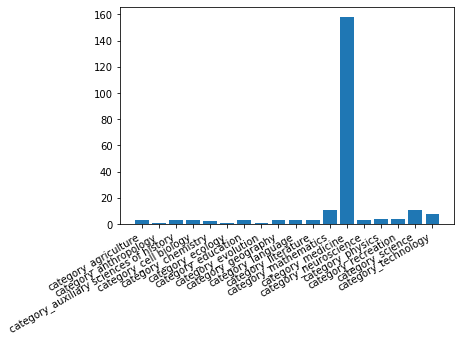

In [37]:

fig, ax = plt.subplots()
plt.bar(count_categories.keys(), count_categories.values())
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.title(f'')
plt.show()

In [38]:

# add categories predictions to their objects in table cat_data_to_predict
predictions = predictions.set_index(cat_data_to_predict.index.copy())
for header in predictions.columns:
    cat_data_to_predict[header] = predictions[header]

# Question 3: RÃ©gression-clustering
## A. Supprimer tous les attributs ayant plus de 50% de donnÃ©es manquantes.

On Ã©tablit les attributs Ã  Ã©liminer selon leur taux de valeurs manquantes avec nos 3 tables originales (journal, price
et influence).
On utilise nos donnÃ©es dÃ©jÃ  travaillÃ©es qui sont dans les tables cat_labelled_data et cat_data_to_predict car celles-ci
prÃ©sentent toutes les donnÃ©es dont nous avons besoin. Comme on a des bons rÃ©sultats de prÃ©dictions, on peut se 
permettre de les utiliser pour la suite du travail. C'est donc sur ces donnÃ©es que nous allons Ã©liminÃ©s ces attributs.
On Ã©tablit alors une nouvelle table (data) avec toutes ces donnÃ©es et les attributs prÃ©sentant trop de valeurs 
manquantes.

In [39]:

print(f'Attributs Ã  Ã©liminer de la table journal: {get_empty_attribute_to_remove(journal)}')
print(f'Attributs Ã  Ã©liminer de la table price: {get_empty_attribute_to_remove(price)}')
print(f'Attributs Ã  Ã©liminer de la table influence: {get_empty_attribute_to_remove(influence)}')

Attributs Ã  Ã©liminer de la table journal: ['url_journal']
Attributs Ã  Ã©liminer de la table price: ['influence_id', 'url_autor', 'license']
Attributs Ã  Ã©liminer de la table influence: []


In [40]:

cat_data_to_predict = cat_data_to_predict.drop(columns='category')
data = cat_labelled_data.append(cat_data_to_predict, sort=False)
data = data.drop(columns=['url_journal', 'influence_id', 'url_autor', 'license'])

## B. Construire un modÃ¨le pour prÃ©dire le coÃ»t actuel de publication (attribut Â«priceÂ») Ã  partir des autres attributs 
(cela inclut la sÃ©lection dâ€™attributs informatifs, le choix et le paramÃ©trage dâ€™un modÃ¨le de rÃ©gression, le calcul du 
score du modÃ¨le, lâ€™application du modÃ¨le pour prÃ©dire les coÃ»ts).Justifier les choix effectuÃ©s.
Lister les 10 revues qui sâ€™Ã©cartent le plus (en + ou -) de la valeur prÃ©dite.
 
 
Tout d'abord, nous dÃ©cidons de ne pas utiliser les attributs Ã  Ã©liminer prÃ©senter un nombre consÃ©quent de valeurs 
manquantes, que nous avons trouvÃ©s dans la question 3.A
 
L'attribut date_stamp dans price Ã©tablissant la date Ã  laquelle le prix a Ã©tÃ© mesurÃ© semble intÃ©ressant.

On a vu question 2B que l'attribut prix n'est pas fortement corrÃ©lÃ©s aux catÃ©gories d'un journal, cependant il existait
certaines catÃ©gories prÃ©sentant une certaine corrÃ©lation non nÃ©gligeable. On peut reprendre alors les catÃ©gories que 
l'on a transformÃ©s en one hot Ã  la question 2.C. Aussi, Ã©tant donnÃ© les bons rÃ©sultats du modÃ¨le de classification des
catÃ©gories trouvÃ© prÃ©cÃ©demment, on envisage d'utiliser Ã©galement ces objets. 
L'information d'un journal sur son hybridicitÃ© pourrait Ã©galement faire varier son prix 

Les attributs de la table influence semblent Ãªtre pertinentes pour la prÃ©diction du prix, en effet, tous les 
informations sur le nombre de citations pourraient se rÃ©vÃ©ler intÃ©ressantes quant Ã  la prÃ©diction du prix d'un 
journal. Aussi, l'attribut informant sur le score d'influence du journal pourrait se rÃ©vÃ©ler intÃ©ressant. 
Etant donnÃ© que l'attribut proj_ai_year prÃ©sente toujours la mÃªme valeur, il n'est pas vraiment pertinent de le 
conserver. 

### Construction et estimation des performances du modÃ¨le

In [41]:

attributes_of_interest = [
    #     'date_stamp',
    'citation_count_sum', 'paper_count_sum', 'avg_cites_per_paper', 'proj_ai',
    'is_hybrid', 'price']
attributes_of_interest.extend(category_dummies_prefix.columns)

In [42]:

price_labelled_data = data[attributes_of_interest]

In [43]:

X_train, X_test, y_train, y_test = train_test_split(price_labelled_data.drop(columns='price'),
                                                    price_labelled_data['price'],
                                                    test_size=0.33, random_state=42)

regr = RandomForestRegressor(max_depth=22, n_estimators=300, n_jobs=-1)
print('-- Entrainement')
regr.fit(X_train, y_train)
train_score = regr.score(X_train, y_train)
print(f'Score d\'entraÃ®nement: {train_score}')

print('-- Test')
test_predictions = regr.predict(X_test)
test_score = regr.score(X_test, y_test)
print(f'Score de test: {test_score}')

-- Entrainement
Score d'entraÃ®nement: 0.9291023324132746
-- Test
Score de test: 0.8039827306554684


### Application du modÃ¨le

In [44]:

predictions = pd.DataFrame(regr.predict(price_labelled_data.drop(columns='price')))
predictions = predictions.set_index(data.index.copy())

In [45]:

difference_pred_real = dict()
for index, p in predictions.iterrows():
    difference_pred_real[data['journal_name'][index]] = abs(p[0] - data['price'][index])

In [52]:
print(f'Journaux dont leur prédiction du prix s\'éloigne le plus de la réalité:\n')
worst_predictions = np.array(heapq.nlargest(10, difference_pred_real, key=difference_pred_real.get))
worst_predictions_values = []
for p in worst_predictions:
    worst_predictions_values.append(difference_pred_real.get(p))
    print(f'{p} : {difference_pred_real.get(p)}')

worst_predictions = np.vstack([worst_predictions, worst_predictions_values])

Journaux dont leur prédiction du prix s'éloigne le plus de la réalité:

international journal of applied research in veterinary medicine : 3646.929535743793
experimental and molecular medicine : 3244.6385167614303
journal of veterinary medical science : 2421.976014392573
annals of thoracic and cardiovascular surgery : 2384.665683409054
ebiomedicine : 2374.2853515584434
bulletin of the american meteorological society : 2229.478635361552
npg asia materials : 2185.5534422407304
canadian journal of diabetes : 1990.3830378787877
journal of the brazilian society of mechanical sciences and engineering : 1988.9836462703593
journal of natural products : 1933.1339023964788


array([['international journal of applied research in veterinary medicine',
        'experimental and molecular medicine',
        'journal of veterinary medical science',
        'annals of thoracic and cardiovascular surgery', 'ebiomedicine',
        'bulletin of the american meteorological society',
        'npg asia materials', 'canadian journal of diabetes',
        'journal of the brazilian society of mechanical sciences and engineering',
        'journal of natural products'],
       ['3646.929535743793', '3244.6385167614303', '2421.976014392573',
        '2384.665683409054', '2374.2853515584434', '2229.478635361552',
        '2185.5534422407304', '1990.3830378787877', '1988.9836462703593',
        '1933.1339023964788']], dtype='<U71')